Notebook to analyze the differences between internal sensors - 2

In [1]:
# Python standard library imports
import time

# Third-party imports for database connection and data manipulation
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
# Third-party imports for mapping
import folium

In [2]:
# Database connection parameters
dbname = 'ar41'
user = 'postgres'
password = '1234'
host = 'localhost'  # localhost or the server address
port = '5432'  # default PostgreSQL port is 5432

# Establish a connection to the database
connection_str = f"postgresql://{user}:{password}@{host}:{port}/{dbname}"
engine = create_engine(connection_str)

1. Analysis of Oil temperature and Water temperature PC1

First of all, we begin by taking a look at the data. Are the values correlated?

      RS_E_WatTemp_PC1    count
0            78.000000  1572267
1            81.000000  1456272
2            82.000000  1448916
3            83.000000  1307128
4            80.000000  1277024
...                ...      ...
1426         78.888889        1
1427         78.909091        1
1428         78.947368        1
1429         78.962264        1
1430         78.964286        1

[1431 rows x 2 columns]
      RS_T_OilTemp_PC1    count
0            82.000000  1241283
1            84.000000  1123455
2            81.000000  1113575
3            79.000000  1034229
4            85.000000  1007849
...                ...      ...
2905         74.074627        1
2906         74.078125        1
2907         89.818182        1
2908         74.090909        1
2909         74.092308        1

[2910 rows x 2 columns]


[]

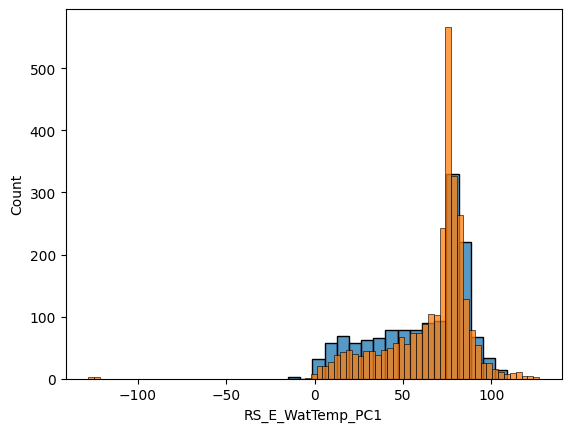

In [3]:
query_wat = f"""
SELECT "RS_E_WatTemp_PC1", COUNT(*) AS Count
FROM vehicle_data_enriched
GROUP BY "RS_E_WatTemp_PC1"
ORDER BY COUNT(*) DESC;
"""

query_oil = f"""
SELECT "RS_T_OilTemp_PC1", COUNT(*) AS Count
FROM vehicle_data_enriched
GROUP BY "RS_T_OilTemp_PC1"
ORDER BY COUNT(*) DESC;
"""

df_wat = pd.read_sql_query(query_wat, engine)
print(df_wat)
sns.histplot(x='RS_E_WatTemp_PC1', data=df_wat)
plt.plot()

df_oil = pd.read_sql_query(query_oil, engine)
print(df_oil)
sns.histplot(x='RS_T_OilTemp_PC1', data=df_oil)
plt.plot()

As it can be seen from the graphics and analysis done in previous notebooks, these values are very correlated. So let's proceed to look at the buckets of temperature differences between the two sensors, and start defining some outlier behavior:

    bucket_range  occurrences
0            0.0     13032236
1            5.0      3562219
2           10.0       734667
3           15.0       154585
4           20.0        27056
5           25.0        12584
6           30.0        10045
7           35.0        13469
8           40.0        12883
9           45.0         9882
10          50.0         7963
11          55.0         6010
12          60.0         4559
13          65.0         5058
14          70.0        16260
15          75.0        28658
16          80.0        28136
17          85.0        11021
18          90.0         1767
19          95.0          114
20         100.0           40
21         105.0           30
22         110.0           14
23         115.0            4
24         120.0            6
25         125.0            4
26         195.0            2
27         200.0            1


[]

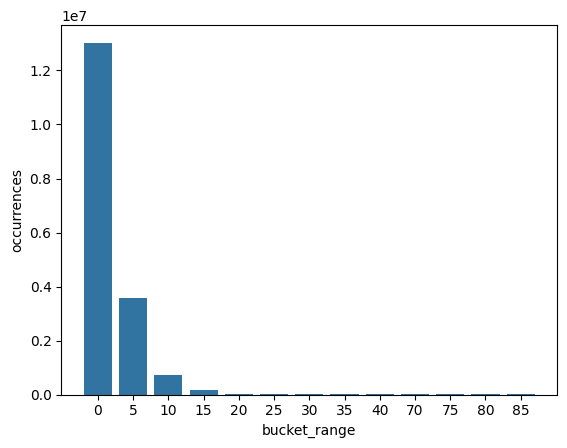

In [4]:
query_buckets_watoil = f"""
WITH TemperatureDifferences AS (
    SELECT
        mapped_veh_id,
        "timestamps_UTC",
        "RS_T_OilTemp_PC1",
        "RS_E_WatTemp_PC1",
        ABS("RS_T_OilTemp_PC1" - "RS_E_WatTemp_PC1") AS temp_difference
    FROM
        vehicle_data_enriched
    WHERE
        "RS_T_OilTemp_PC1" IS NOT NULL
        AND "RS_E_WatTemp_PC1" IS NOT NULL
)
SELECT
    bucket_range,
    COUNT(*) AS occurrences
FROM (
    SELECT
        mapped_veh_id,
        "timestamps_UTC",
        "RS_T_OilTemp_PC1",
        "RS_E_WatTemp_PC1",
        temp_difference,
        floor(temp_difference / 5) * 5 AS bucket_range
    FROM
        TemperatureDifferences
) AS temp_diff_buckets
GROUP BY
    bucket_range
ORDER BY
    bucket_range;
"""

df_buckets_watoil = pd.read_sql_query(query_buckets_watoil, engine)
print(df_buckets_watoil)
df_buckets_watoil['bucket_range'] = df_buckets_watoil['bucket_range'].astype(int)
df_buckets_watoil = df_buckets_watoil[df_buckets_watoil['occurrences']>10000]
sns.barplot(x='bucket_range', y='occurrences', data=df_buckets_watoil)
plt.plot()


Following the barplot, after 15°C of absolute difference, the buckets seem to encounter the same amount of low occurrences. Taking this in consideration, we assign a >20 threshold to keep analyzing data.

So again, we come back to a question we have asked while comparing two sensors: does this problem persist over time? is it just random and isolated occurrences during the day?

To answer this question, we perform a continous query, where we make groups of vehicle and timestamps, where the temperature difference is consistent among timestamps for a long period. If 10 minutes go by from having an absolute difference above 20, then we consider the continous trend ended. With this, we'll end with groups of vehicles and how long the absolute difference of temperature persisted over time.

For this analysis, we are adding more constraints:
* We don't care about records when either one of the two sensors is shut down
* We avoid considering temperatures above the acceptable boundaries for both type of sensors (115 & 100)
* We don't consider NULL values

   mapped_veh_id  group  count  starting_timestamp    ending_timestamp  \
0          152.0     11   1288 2023-03-19 22:55:21 2023-03-20 09:43:27   
1          125.0      1   1134 2023-01-23 08:29:46 2023-01-23 18:27:57   
2          178.0     91   1079 2023-03-23 12:50:17 2023-03-23 22:24:36   
3          183.0     96    715 2023-08-06 20:23:09 2023-08-07 02:28:36   
4          125.0     20    351 2023-03-09 00:14:39 2023-03-09 06:06:41   
5          170.0      9    613 2023-02-13 02:34:44 2023-02-13 07:43:54   
6          105.0     15    306 2023-03-07 05:21:45 2023-03-07 10:30:51   
7          181.0     72    705 2023-03-11 04:24:19 2023-03-11 09:30:47   
8          178.0     82    615 2023-03-01 21:32:15 2023-03-02 02:38:20   
9          144.0     74    594 2023-03-13 08:59:31 2023-03-13 13:56:41   

   duration_minutes  
0        648.100000  
1        598.183333  
2        574.316667  
3        365.450000  
4        352.033333  
5        309.166667  
6        309.100000  
7        

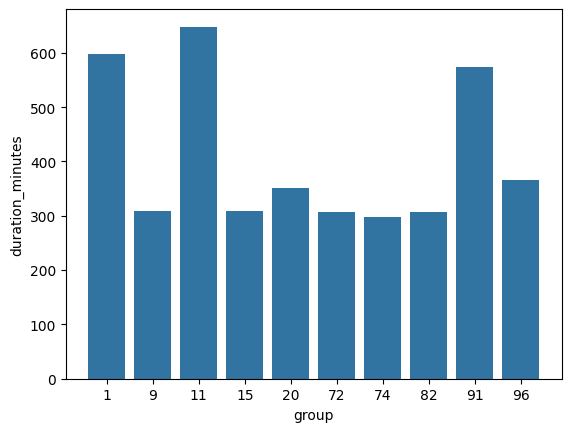

In [13]:
query_difference_watoil = f"""
WITH selected_data AS (
    SELECT
        mapped_veh_id,
        "timestamps_UTC"::TIMESTAMP,
        "RS_T_OilTemp_PC1",
        "RS_E_WatTemp_PC1",
        ABS("RS_T_OilTemp_PC1" - "RS_E_WatTemp_PC1") AS temp_difference,
        LAG("timestamps_UTC"::TIMESTAMP) OVER (PARTITION BY mapped_veh_id ORDER BY "timestamps_UTC") AS prev_timestamp
    FROM
        vehicle_data_enriched
    WHERE
        "RS_T_OilTemp_PC1" IS NOT NULL
        AND "RS_E_WatTemp_PC1" IS NOT NULL
        AND "RS_T_OilTemp_PC1" < 115
        AND "RS_E_WatTemp_PC1" < 100
        AND ("RS_T_OilTemp_PC1" != 0 AND "RS_E_WatTemp_PC1" != 0)
        AND ABS("RS_T_OilTemp_PC1" - "RS_E_WatTemp_PC1") > 20
)
, grouped_data AS (
    SELECT
        mapped_veh_id,
        "timestamps_UTC",
        temp_difference,
        SUM(CASE WHEN "timestamps_UTC" - prev_timestamp > INTERVAL '10' MINUTE OR prev_timestamp IS NULL THEN 1 ELSE 0 END) OVER (PARTITION BY mapped_veh_id ORDER BY "timestamps_UTC") AS new_group
    FROM
        selected_data
)
SELECT
    mapped_veh_id,
    new_group AS group,
    COUNT(*) AS count,
    MIN("timestamps_UTC") AS starting_timestamp,
    MAX("timestamps_UTC") AS ending_timestamp,
    EXTRACT(EPOCH FROM (MAX("timestamps_UTC") - MIN("timestamps_UTC"))) / 60 AS duration_minutes
FROM
    grouped_data
GROUP BY
    mapped_veh_id,
    new_group
HAVING
    COUNT(*) > 1
ORDER BY
    duration_minutes DESC;
"""

df_difference_watoil = pd.read_sql_query(query_difference_watoil, engine)
print(df_difference_watoil.head(10))
sns.barplot(y='duration_minutes', x='group', data=df_difference_watoil.head(10))
plt.plot()
df_difference_watoil.to_csv('WaterOilSensorDiff.csv', sep=',', index=False, encoding='utf-8')

These are only the top 10 continuous cases of absolute difference and all of them are ~5 hours long.

Let's plot one of the cases (we plot before and after the starting and ending timestamps, to see the changes):

<Axes: xlabel='timestamps_UTC', ylabel='abs'>

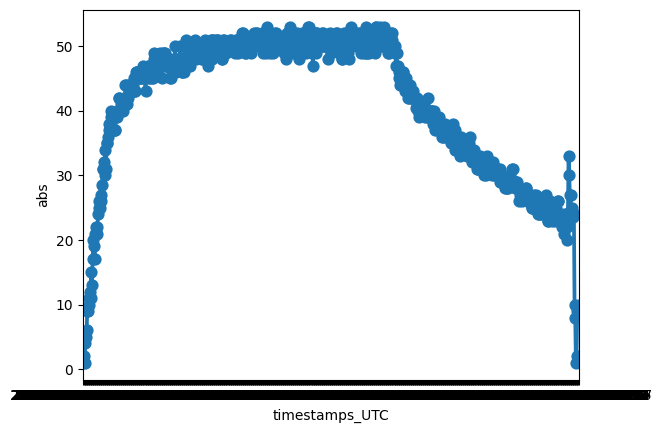

In [6]:
query_example_watoil = f"""
SELECT mapped_veh_id, "timestamps_UTC", "RS_T_OilTemp_PC1", "RS_E_WatTemp_PC1", abs("RS_T_OilTemp_PC1"-"RS_E_WatTemp_PC1")
FROM vehicle_data_enriched
WHERE mapped_veh_id = 183 AND "timestamps_UTC" BETWEEN '2023-08-06 20:03:09.000000' AND '2023-08-07 02:48:36.000000'
ORDER BY "timestamps_UTC";
"""

df_example_watoil = pd.read_sql_query(query_example_watoil, engine)
sns.pointplot(x='timestamps_UTC', y='abs', data=df_example_watoil)

Now we consider the a new threshold to define the outliers. What duration is enough to tell that the problem is abnormal? Following an arbitrary selection we choose an hour as our threshold:

In [10]:
query_difference_watoil2 = f"""
WITH selected_data AS (
    SELECT
        mapped_veh_id,
        "timestamps_UTC"::TIMESTAMP,
        "RS_E_InAirTemp_PC1",
        "RS_E_InAirTemp_PC2",
        ABS("RS_T_OilTemp_PC1" - "RS_E_WatTemp_PC1") AS temp_difference,
        LAG("timestamps_UTC"::TIMESTAMP) OVER (PARTITION BY mapped_veh_id ORDER BY "timestamps_UTC") AS prev_timestamp,
        lat,
        lon,
        "RS_E_OilPress_PC1",
        "RS_E_OilPress_PC2",
        rs_e_rpm_pc1,
        rs_e_rpm_pc2,
        "RS_E_WatTemp_PC1",
        "RS_E_WatTemp_PC2",
        "RS_T_OilTemp_PC1",
        "RS_T_OilTemp_PC2",
        timestamps_floor,
        nearest_point_id,
        "Lat",
        "Lon",
        "Time",
        "Temperature",
        "Humidity",
        "Rain"
    FROM
        vehicle_data_enriched
    WHERE
        "RS_T_OilTemp_PC1" IS NOT NULL
        AND "RS_E_WatTemp_PC1" IS NOT NULL
        AND "RS_T_OilTemp_PC1" < 115
        AND "RS_E_WatTemp_PC1" < 100
        AND ("RS_T_OilTemp_PC1" != 0 AND "RS_E_WatTemp_PC1" != 0)
        AND ABS("RS_T_OilTemp_PC1" - "RS_E_WatTemp_PC1") > 20
),
grouped_data AS (
    SELECT
        mapped_veh_id,
        "timestamps_UTC",
        temp_difference,
        SUM(CASE WHEN "timestamps_UTC" - prev_timestamp > INTERVAL '10' MINUTE OR prev_timestamp IS NULL THEN 1 ELSE 0 END) OVER (PARTITION BY mapped_veh_id ORDER BY "timestamps_UTC") AS new_group
    FROM
        selected_data
),
group_durations AS (
    SELECT
        mapped_veh_id,
        new_group AS group,
        MIN("timestamps_UTC") AS starting_timestamp,
        MAX("timestamps_UTC") AS ending_timestamp,
        EXTRACT(EPOCH FROM (MAX("timestamps_UTC") - MIN("timestamps_UTC"))) / 60 AS duration_minutes
    FROM
        grouped_data
    GROUP BY
        mapped_veh_id, new_group
    HAVING
        COUNT(*) > 1
)
, average_duration AS (
    SELECT
        AVG(duration_minutes) AS avg_duration
    FROM
        group_durations
)
SELECT
    sd.mapped_veh_id,
    sd."timestamps_UTC" AS timestamp,
    sd."RS_E_InAirTemp_PC1",
    sd."RS_E_InAirTemp_PC2",
    sd.temp_difference,
    sd.lat,
    sd.lon,
    sd."RS_E_OilPress_PC1",
    sd."RS_E_OilPress_PC2",
    sd.rs_e_rpm_pc1,
    sd.rs_e_rpm_pc2,
    sd."RS_E_WatTemp_PC1",
    sd."RS_E_WatTemp_PC2",
    sd."RS_T_OilTemp_PC1",
    sd."RS_T_OilTemp_PC2",
    sd.timestamps_floor,
    sd.nearest_point_id,
    sd."Lat",
    sd."Lon",
    sd."Time",
    sd."Temperature",
    sd."Humidity",
    sd."Rain"
FROM
    selected_data sd
JOIN
    grouped_data gd ON sd.mapped_veh_id = gd.mapped_veh_id AND sd."timestamps_UTC" = gd."timestamps_UTC"
JOIN
    group_durations gdd ON gd.mapped_veh_id = gdd.mapped_veh_id AND gd.new_group = gdd.group
JOIN
    average_duration ad ON 1=1
WHERE
    gdd.duration_minutes > 60
ORDER BY
    sd.mapped_veh_id,
    sd."timestamps_UTC";
"""

df_difference_watoil2 = pd.read_sql_query(query_difference_watoil2, engine)
df_difference_watoil2['outlier_type'] = 'WaterOilDelta'
print(df_difference_watoil2)
df_difference_watoil2.to_csv('R10-2-1.csv', sep=',', index=False, encoding='utf-8')

       mapped_veh_id           timestamp  RS_E_InAirTemp_PC1  \
0              104.0 2023-01-24 00:59:53                41.0   
1              104.0 2023-01-24 01:00:54                41.0   
2              104.0 2023-01-24 01:01:54                42.0   
3              104.0 2023-01-24 01:02:57                42.0   
4              104.0 2023-01-24 01:05:58                42.0   
...              ...                 ...                 ...   
36074          197.0 2023-03-06 13:53:52                 3.0   
36075          197.0 2023-03-06 13:54:51                14.0   
36076          197.0 2023-03-06 13:54:53                 3.0   
36077          197.0 2023-03-06 13:55:56                 3.0   
36078          197.0 2023-03-06 13:56:56                 3.0   

       RS_E_InAirTemp_PC2  temp_difference        lat       lon  \
0                    13.0             23.0  50.418798  4.534207   
1                    13.0             23.0  50.418799  4.534191   
2                    13.0     

This yields a total of ~36K outliers, from sensor differences between Oil and Water temperature.

Let's use the same logic to find how this works with the other pair of sensors (PC2).

2. Analysis of Oil temperature and Water temperature PC2

In [12]:
query_difference_watoil3 = f"""
WITH selected_data AS (
    SELECT
        mapped_veh_id,
        "timestamps_UTC"::TIMESTAMP,
        "RS_E_InAirTemp_PC1",
        "RS_E_InAirTemp_PC2",
        ABS("RS_T_OilTemp_PC2" - "RS_E_WatTemp_PC2") AS temp_difference,
        LAG("timestamps_UTC"::TIMESTAMP) OVER (PARTITION BY mapped_veh_id ORDER BY "timestamps_UTC") AS prev_timestamp,
        lat,
        lon,
        "RS_E_OilPress_PC1",
        "RS_E_OilPress_PC2",
        rs_e_rpm_pc1,
        rs_e_rpm_pc2,
        "RS_E_WatTemp_PC1",
        "RS_E_WatTemp_PC2",
        "RS_T_OilTemp_PC1",
        "RS_T_OilTemp_PC2",
        timestamps_floor,
        nearest_point_id,
        "Lat",
        "Lon",
        "Time",
        "Temperature",
        "Humidity",
        "Rain"
    FROM
        vehicle_data_enriched
    WHERE
        "RS_T_OilTemp_PC2" IS NOT NULL
        AND "RS_E_WatTemp_PC2" IS NOT NULL
        AND "RS_T_OilTemp_PC2" < 115
        AND "RS_E_WatTemp_PC2" < 100
        AND ("RS_T_OilTemp_PC2" != 0 AND "RS_E_WatTemp_PC2" != 0)
        AND ABS("RS_T_OilTemp_PC2" - "RS_E_WatTemp_PC2") > 20
),
grouped_data AS (
    SELECT
        mapped_veh_id,
        "timestamps_UTC",
        temp_difference,
        SUM(CASE WHEN "timestamps_UTC" - prev_timestamp > INTERVAL '10' MINUTE OR prev_timestamp IS NULL THEN 1 ELSE 0 END) OVER (PARTITION BY mapped_veh_id ORDER BY "timestamps_UTC") AS new_group
    FROM
        selected_data
),
group_durations AS (
    SELECT
        mapped_veh_id,
        new_group AS group,
        MIN("timestamps_UTC") AS starting_timestamp,
        MAX("timestamps_UTC") AS ending_timestamp,
        EXTRACT(EPOCH FROM (MAX("timestamps_UTC") - MIN("timestamps_UTC"))) / 60 AS duration_minutes
    FROM
        grouped_data
    GROUP BY
        mapped_veh_id, new_group
    HAVING
        COUNT(*) > 1
)
, average_duration AS (
    SELECT
        AVG(duration_minutes) AS avg_duration
    FROM
        group_durations
)
SELECT
    sd.mapped_veh_id,
    sd."timestamps_UTC" AS timestamp,
    sd."RS_E_InAirTemp_PC1",
    sd."RS_E_InAirTemp_PC2",
    sd.temp_difference,
    sd.lat,
    sd.lon,
    sd."RS_E_OilPress_PC1",
    sd."RS_E_OilPress_PC2",
    sd.rs_e_rpm_pc1,
    sd.rs_e_rpm_pc2,
    sd."RS_E_WatTemp_PC1",
    sd."RS_E_WatTemp_PC2",
    sd."RS_T_OilTemp_PC1",
    sd."RS_T_OilTemp_PC2",
    sd.timestamps_floor,
    sd.nearest_point_id,
    sd."Lat",
    sd."Lon",
    sd."Time",
    sd."Temperature",
    sd."Humidity",
    sd."Rain"
FROM
    selected_data sd
JOIN
    grouped_data gd ON sd.mapped_veh_id = gd.mapped_veh_id AND sd."timestamps_UTC" = gd."timestamps_UTC"
JOIN
    group_durations gdd ON gd.mapped_veh_id = gdd.mapped_veh_id AND gd.new_group = gdd.group
JOIN
    average_duration ad ON 1=1
WHERE
    gdd.duration_minutes > 60
ORDER BY
    sd.mapped_veh_id,
    sd."timestamps_UTC";
"""

df_difference_watoil3 = pd.read_sql_query(query_difference_watoil3, engine)
df_difference_watoil3['outlier_type'] = 'WaterOilDelta'
print(df_difference_watoil3)
df_difference_watoil3.to_csv('R10-2-2.csv', sep=',', index=False, encoding='utf-8')


        mapped_veh_id           timestamp  RS_E_InAirTemp_PC1  \
0               104.0 2023-05-01 23:01:33                13.0   
1               104.0 2023-05-01 23:02:33                13.0   
2               104.0 2023-05-01 23:04:36                13.0   
3               104.0 2023-05-01 23:05:37                13.0   
4               104.0 2023-05-01 23:06:36                13.0   
...               ...                 ...                 ...   
106505          196.0 2023-06-16 07:12:08                45.0   
106506          196.0 2023-06-16 07:12:56                48.0   
106507          196.0 2023-06-16 07:13:09                48.0   
106508          196.0 2023-06-16 07:13:26                50.0   
106509          196.0 2023-06-16 07:13:28                50.0   

        RS_E_InAirTemp_PC2  temp_difference        lat       lon  \
0                     30.0             21.0  50.419021  4.533925   
1                     31.0             22.0  50.419042  4.533902   
2              

Surprisingly, we get a very big difference. Let's go back some steps to see what may be the issue.

Let's see how duration groups look for the PC2 sensors:

In [14]:
query_difference_watoil4 = f"""
WITH selected_data AS (
    SELECT
        mapped_veh_id,
        "timestamps_UTC"::TIMESTAMP,
        "RS_T_OilTemp_PC2",
        "RS_E_WatTemp_PC2",
        ABS("RS_T_OilTemp_PC2" - "RS_E_WatTemp_PC2") AS temp_difference,
        LAG("timestamps_UTC"::TIMESTAMP) OVER (PARTITION BY mapped_veh_id ORDER BY "timestamps_UTC") AS prev_timestamp
    FROM
        vehicle_data_enriched
    WHERE
        "RS_T_OilTemp_PC2" IS NOT NULL
        AND "RS_E_WatTemp_PC2" IS NOT NULL
        AND "RS_T_OilTemp_PC2" < 115
        AND "RS_E_WatTemp_PC2" < 100
        AND ("RS_T_OilTemp_PC2" != 0 AND "RS_E_WatTemp_PC2" != 0)
        AND ABS("RS_T_OilTemp_PC2" - "RS_E_WatTemp_PC2") > 20
),
grouped_data AS (
    SELECT
        mapped_veh_id,
        "timestamps_UTC",
        temp_difference,
        SUM(CASE WHEN "timestamps_UTC" - prev_timestamp > INTERVAL '10' MINUTE OR prev_timestamp IS NULL THEN 1 ELSE 0 END) OVER (PARTITION BY mapped_veh_id ORDER BY "timestamps_UTC") AS new_group
    FROM
        selected_data
),
group_durations AS (
    SELECT
        mapped_veh_id,
        new_group AS group,
        MIN("timestamps_UTC") AS starting_timestamp,
        MAX("timestamps_UTC") AS ending_timestamp,
        EXTRACT(EPOCH FROM (MAX("timestamps_UTC") - MIN("timestamps_UTC"))) / 60 AS duration_minutes
    FROM
        grouped_data
    GROUP BY
        mapped_veh_id, new_group
    HAVING
        COUNT(*) > 1
)
, average_duration AS (
    SELECT
        AVG(duration_minutes) AS avg_duration
    FROM
        group_durations
)
SELECT
    sd.mapped_veh_id,
    sd."timestamps_UTC" AS timestamp,
    sd."RS_T_OilTemp_PC2",
    sd."RS_E_WatTemp_PC2",
    sd.temp_difference
FROM
    selected_data sd
JOIN
    grouped_data gd ON sd.mapped_veh_id = gd.mapped_veh_id AND sd."timestamps_UTC" = gd."timestamps_UTC"
JOIN
    group_durations gdd ON gd.mapped_veh_id = gdd.mapped_veh_id AND gd.new_group = gdd.group
JOIN
    average_duration ad ON 1=1
WHERE
    gdd.duration_minutes > 60 AND gdd.mapped_veh_id != 107
ORDER BY
    sd.mapped_veh_id,
    sd."timestamps_UTC";

WITH selected_data AS (
    SELECT
        mapped_veh_id,
        "timestamps_UTC"::TIMESTAMP,
        "RS_T_OilTemp_PC2",
        "RS_E_WatTemp_PC2",
        ABS("RS_T_OilTemp_PC2" - "RS_E_WatTemp_PC2") AS temp_difference,
        LAG("timestamps_UTC"::TIMESTAMP) OVER (PARTITION BY mapped_veh_id ORDER BY "timestamps_UTC") AS prev_timestamp
    FROM
        vehicle_data_enriched
    WHERE
        "RS_T_OilTemp_PC2" IS NOT NULL
        AND "RS_E_WatTemp_PC2" IS NOT NULL
        AND "RS_T_OilTemp_PC2" < 115
        AND "RS_E_WatTemp_PC2" < 100
        AND ("RS_T_OilTemp_PC2" != 0 AND "RS_E_WatTemp_PC2" != 0)
        AND ABS("RS_T_OilTemp_PC2" - "RS_E_WatTemp_PC2") > 20
)
, grouped_data AS (
    SELECT
        mapped_veh_id,
        "timestamps_UTC",
        temp_difference,
        SUM(CASE WHEN "timestamps_UTC" - prev_timestamp > INTERVAL '10' MINUTE OR prev_timestamp IS NULL THEN 1 ELSE 0 END) OVER (PARTITION BY mapped_veh_id ORDER BY "timestamps_UTC") AS new_group
    FROM
        selected_data
)
SELECT
    mapped_veh_id,
    new_group AS group,
    COUNT(*) AS count,
    MIN("timestamps_UTC") AS starting_timestamp,
    MAX("timestamps_UTC") AS ending_timestamp,
    EXTRACT(EPOCH FROM (MAX("timestamps_UTC") - MIN("timestamps_UTC"))) / 60 AS duration_minutes
FROM
    grouped_data
GROUP BY
    mapped_veh_id,
    new_group
HAVING
    COUNT(*) > 1
ORDER BY
    duration_minutes DESC;
"""

df_difference_watoil4 = pd.read_sql_query(query_difference_watoil4, engine)
print(df_difference_watoil4)
df_difference_watoil4.to_csv('WaterOilSensorDiff2.csv', sep=',', index=False, encoding='utf-8')

      mapped_veh_id  group  count  starting_timestamp    ending_timestamp  \
0             107.0     74   1915 2023-03-21 11:30:33 2023-03-22 19:34:03   
1             107.0     23   1860 2023-02-06 14:23:27 2023-02-07 19:49:54   
2             107.0    164   1677 2023-07-25 11:27:06 2023-07-26 16:05:33   
3             107.0     31   1488 2023-02-11 15:07:36 2023-02-12 16:57:54   
4             107.0    103   1368 2023-04-03 19:42:42 2023-04-04 18:47:03   
...             ...    ...    ...                 ...                 ...   
4017          178.0    204      2 2023-06-21 21:33:09 2023-06-21 21:33:10   
4018          177.0     99      2 2023-06-27 17:27:19 2023-06-27 17:27:20   
4019          145.0     26      2 2023-02-03 17:33:32 2023-02-03 17:33:33   
4020          108.0     90      2 2023-06-09 08:57:08 2023-06-09 08:57:09   
4021          150.0    249      2 2023-08-29 21:58:29 2023-08-29 21:58:30   

      duration_minutes  
0          1923.500000  
1          1766.450000  


There is a clear problem with mapped_veh_id 107. What if we perform again the outlier output, excluding results coming from the vehicle 107?

In [ ]:
query_difference_watoil5 = f"""
WITH selected_data AS (
    SELECT
        mapped_veh_id,
        "timestamps_UTC"::TIMESTAMP,
        "RS_T_OilTemp_PC2",
        "RS_E_WatTemp_PC2",
        ABS("RS_T_OilTemp_PC2" - "RS_E_WatTemp_PC2") AS temp_difference,
        LAG("timestamps_UTC"::TIMESTAMP) OVER (PARTITION BY mapped_veh_id ORDER BY "timestamps_UTC") AS prev_timestamp
    FROM
        vehicle_data_enriched
    WHERE
        "RS_T_OilTemp_PC2" IS NOT NULL
        AND "RS_E_WatTemp_PC2" IS NOT NULL
        AND "RS_T_OilTemp_PC2" < 115
        AND "RS_E_WatTemp_PC2" < 100
        AND ("RS_T_OilTemp_PC2" != 0 AND "RS_E_WatTemp_PC2" != 0)
        AND ABS("RS_T_OilTemp_PC2" - "RS_E_WatTemp_PC2") > 20
),
grouped_data AS (
    SELECT
        mapped_veh_id,
        "timestamps_UTC",
        temp_difference,
        SUM(CASE WHEN "timestamps_UTC" - prev_timestamp > INTERVAL '10' MINUTE OR prev_timestamp IS NULL THEN 1 ELSE 0 END) OVER (PARTITION BY mapped_veh_id ORDER BY "timestamps_UTC") AS new_group
    FROM
        selected_data
),
group_durations AS (
    SELECT
        mapped_veh_id,
        new_group AS group,
        MIN("timestamps_UTC") AS starting_timestamp,
        MAX("timestamps_UTC") AS ending_timestamp,
        EXTRACT(EPOCH FROM (MAX("timestamps_UTC") - MIN("timestamps_UTC"))) / 60 AS duration_minutes
    FROM
        grouped_data
    GROUP BY
        mapped_veh_id, new_group
    HAVING
        COUNT(*) > 1
)
, average_duration AS (
    SELECT
        AVG(duration_minutes) AS avg_duration
    FROM
        group_durations
)
SELECT
    sd.mapped_veh_id,
    sd."timestamps_UTC" AS timestamp,
    sd."RS_T_OilTemp_PC2",
    sd."RS_E_WatTemp_PC2",
    sd.temp_difference
FROM
    selected_data sd
JOIN
    grouped_data gd ON sd.mapped_veh_id = gd.mapped_veh_id AND sd."timestamps_UTC" = gd."timestamps_UTC"
JOIN
    group_durations gdd ON gd.mapped_veh_id = gdd.mapped_veh_id AND gd.new_group = gdd.group
JOIN
    average_duration ad ON 1=1
WHERE
    gdd.duration_minutes > 60 AND gdd.mapped_veh_id != 107
ORDER BY
    sd.mapped_veh_id,
    sd."timestamps_UTC";
"""

df_difference_watoil5 = pd.read_sql_query(query_difference_watoil5, engine)
print(df_difference_watoil5)

       mapped_veh_id           timestamp  RS_T_OilTemp_PC2  RS_E_WatTemp_PC2  \
0              104.0 2023-05-01 23:01:33              20.0              41.0   
1              104.0 2023-05-01 23:02:33              20.0              42.0   
2              104.0 2023-05-01 23:04:36              21.0              43.0   
3              104.0 2023-05-01 23:05:37              22.0              43.0   
4              104.0 2023-05-01 23:06:36              21.0              43.0   
...              ...                 ...               ...               ...   
40550          196.0 2023-06-16 07:12:08              34.0              66.0   
40551          196.0 2023-06-16 07:12:56              35.0              66.0   
40552          196.0 2023-06-16 07:13:09              36.0              66.0   
40553          196.0 2023-06-16 07:13:26              35.0              65.0   
40554          196.0 2023-06-16 07:13:28              35.0              65.0   

       temp_difference  
0             

This time we get more "normal" results, considering the cases of the PC1 sensors. However, we can't exclude the values coming from vehicle 107, because it clearly is an outlier so the total output of outliers for both sensors will be of around 140K.

In [ ]:
print(len(df_difference_watoil2)+len(df_difference_watoil3))

142589
